In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import csv
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
print(tf.__version__)

1.10.0


In [2]:
# LOAD DATA
# x_train = np.load("train_x.npy")
# valence_y_train = np.load("valence_train_y.npy")
# x_test = np.load("test_x.npy")
# valence_y_test = np.load("valence_test_y.npy")

# valence_y_train = valence_y_train.flatten()
# valence_y_test = valence_y_test.flatten()

# # Shuffle the training set
# order = np.argsort(np.random.random(valence_y_train.shape))
# x_train = x_train[order]
# valence_y_train = valence_y_train[order]

audio_data = np.load("audio_data.npy")
valence_labels = np.load("valence_labels.npy")

x_train, x_test, valence_y_train, valence_y_test = train_test_split(
    audio_data, valence_labels, test_size=0.4, random_state=0)

print("training set: {}".format(x_train.shape))
print("valence_y_train: {}".format(valence_y_train.shape))
print("testing set: {}".format(x_test.shape))
print("valence_y_test: {}".format(valence_y_test.shape))

training set: (1081, 193)
valence_y_train: (1081,)
testing set: (721, 193)
valence_y_test: (721,)


In [3]:
# kf = KFold(n_splits=10, shuffle=True) # Define the split - into 10 folds 
# kf.get_n_splits(audio_data) # returns the number of splitting iterations in the cross-validator
# print(kf) 

# for train_index, test_index in kf.split(audio_data):
#     print('TRAIN:', train_index, 'TEST:', test_index)
#     X_train, X_test = audio_data[train_index], audio_data[test_index]
#     y_train, y_test = valence_labels[train_index], valence_labels[test_index]

In [4]:
# Normalize the data

print(x_train[0][1], type(x_train[0][1]))  # Display sample features, notice the different scales

# Using mean and standard deviation
# mean = x_train.mean(axis=0)
# std = x_train.std(axis=0)
# x_train = (x_train - mean) / std
# x_test = (x_test - mean) / std

# Using keras utilities normalize
x_train = keras.utils.normalize(x_train, axis=1)  # scales data between 0 and 1
x_test = keras.utils.normalize(x_test, axis=1)  # scales data between 0 and 1

print(x_train[0][1], type(x_train[0][1]))


219.8820632857511 <class 'numpy.float64'>
0.6558553177043096 <class 'numpy.float64'>


In [5]:
def build_model():
  model = keras.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu, 
                       input_shape=(x_train.shape[1],)),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(1)
  ])

  optimizer = tf.train.RMSPropOptimizer(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
  return model

model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                12416     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 16,641
Trainable params: 16,641
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Display training progress by printing a single dot for each completed epoch.
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 500

# Store training stats
history = model.fit(x_train, valence_y_train, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................

In [7]:
import matplotlib.pyplot as plt


def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [Valence]')
  plt.plot(history.epoch, np.array(history.history['mean_absolute_error']), 
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
  plt.legend()
  plt.ylim([0,5])

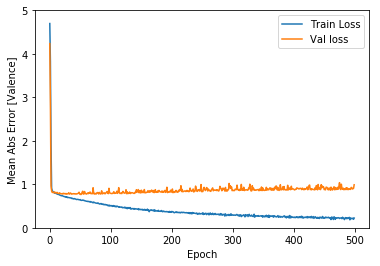

In [8]:
plot_history(history)


......................................................

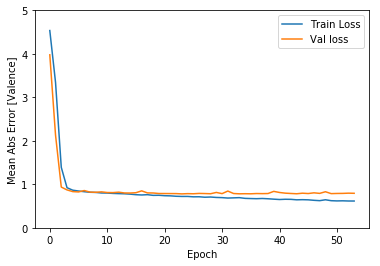

In [9]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = model.fit(x_train, valence_y_train, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[early_stop, PrintDot()])

plot_history(history)

In [10]:
[loss, mae] = model.evaluate(x_test, valence_y_test, verbose=0)

print("Testing set Mean Abs Error:{:7.2f}".format(mae))

Testing set Mean Abs Error:   0.75


In [11]:
test_predictions = model.predict(x_test).flatten()

print(len(test_predictions))
print(len(valence_y_test))

721
721


In [12]:
less_than_one=0
less_than_two=0
less_than_three=0
not_manageable=0

for i in range(len(valence_y_test)):
    diff = abs(test_predictions[i] - valence_y_test[i])
    if(diff < 1):
        less_than_one = less_than_one + 1
    elif(diff < 2):
        less_than_two = less_than_two + 1
    elif(diff < 3):
        less_than_three = less_than_three + 1
    else:
        not_manageable = not_manageable + 1
        print("test[{}] - values different by {:.1f}".format(i,diff))
    print("test[{0:}] - expected: {1:.1f}, prediction: {2:.1f}".format(i,test_predictions[i],valence_y_test[i]))
print("Summary of Differences:\nLess than one: {}\nLess than two: {}\nLess than three: {}\nUnmanageable: {}".format(less_than_one,less_than_two,less_than_three,not_manageable))


# print("test[436] - expected: {0:.1f}, prediction: {1:.1f}".format(test_predictions[436],valence_y_test[436]))

test[0] - expected: 5.5, prediction: 4.5
test[1] - expected: 4.6, prediction: 4.4
test[2] - expected: 5.3, prediction: 5.0
test[3] - expected: 4.7, prediction: 6.1
test[4] - expected: 6.4, prediction: 5.1
test[5] - expected: 5.0, prediction: 4.4
test[6] - expected: 5.3, prediction: 3.7
test[7] - expected: 3.6, prediction: 3.2
test[8] - expected: 6.0, prediction: 5.8
test[9] - expected: 5.2, prediction: 6.3
test[10] - expected: 4.5, prediction: 3.9
test[11] - expected: 4.3, prediction: 3.7
test[12] - expected: 3.8, prediction: 4.2
test[13] - expected: 5.4, prediction: 4.1
test[14] - expected: 4.9, prediction: 5.2
test[15] - expected: 4.5, prediction: 4.0
test[16] - expected: 6.3, prediction: 7.0
test[17] - expected: 5.5, prediction: 6.1
test[18] - expected: 6.7, prediction: 7.4
test[19] - expected: 5.4, prediction: 6.0
test[20] - expected: 4.9, prediction: 4.2
test[21] - expected: 4.6, prediction: 4.3
test[22] - expected: 6.0, prediction: 5.0
test[23] - expected: 4.9, prediction: 5.8
te

In [13]:
print("Test Samples Accounted for: {}/{}".format(less_than_one+less_than_two+less_than_three+not_manageable,len(valence_y_test)))

Test Samples Accounted for: 721/721
